# Lab07 - Image Processing and Analysis
Full name: Đinh Anh Huy - ID Student: 18110103

In [1]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from pylab import imread
from skimage.color import rgb2gray
import warnings
warnings.filterwarnings('ignore')

In [2]:
def ShowImage(ImageList, nRows = 1, nCols = 2, WidthSpace = 0.00, HeightSpace = 0.00):
    from matplotlib import pyplot as plt
    import matplotlib.gridspec as gridspec
    gs = gridspec.GridSpec(nRows, nCols)
    gs.update(wspace=WidthSpace, hspace=HeightSpace) # set the spacing between axes.
    plt.figure(figsize=(20,20))
    for i in range(len(ImageList)):
        ax1 = plt.subplot(gs[i])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        
        plt.subplot(nRows, nCols,i+1)
        
        image = ImageList[i].copy()
        if (len(image.shape) < 3):
            plt.imshow(image, plt.cm.gray)
        else:
            plt.imshow(image)
        plt.title("Image " + str(i))
        plt.axis('off')
        
    plt.show()

In [3]:
def InfoImage(IM):
    Image = IM
    Width = Image.shape[1]
    Height = Image.shape[0]
    Channel = len(Image.shape)
    print("Width : ", Width, " Height : ", Height, " Channel : ", Channel)
    
    if(Channel == 2):
        print("Min Intensity: ", IM.min(), " Max Intensity: ", IM.max())
    else:
        print("Red - Min Intensity: ", IM[:,:,0].min(), " Max Intensity: ", IM[:,:,0].max())
        print("Green - Min Intensity: ", IM[:,:,1].min(), " Max Intensity: ", IM[:,:,1].max())
        print("Blue - Min Intensity: ", IM[:,:,2].min(), " Max Intensity: ", IM[:,:,2].max())

In [4]:
def ResizeImage(IM, DesiredWidth, DesiredHeight):
    from skimage.transform import rescale, resize
    
    OrigWidth = float(IM.shape[1])
    OrigHeight = float(IM.shape[0])
    Width = DesiredWidth
    Height = DesiredHeight
    if((Width == 0) & (Height == 0)):
        return IM
    if(Width == 0):
        Width = int((OrigWidth * Height)/OrigHeight)
    if(Height == 0):
        Height = int((OrigHeight * Width)/OrigWidth)
        
    dim = (Width, Height)
    resizedIM = cv2.resize(IM, dim, interpolation = cv2.INTER_NEAREST)
    return resizedIM

In [5]:
def read_image(img_path):
    img_color = imread(img_path)
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_RGB2GRAY)
    return (img_color, img_gray)

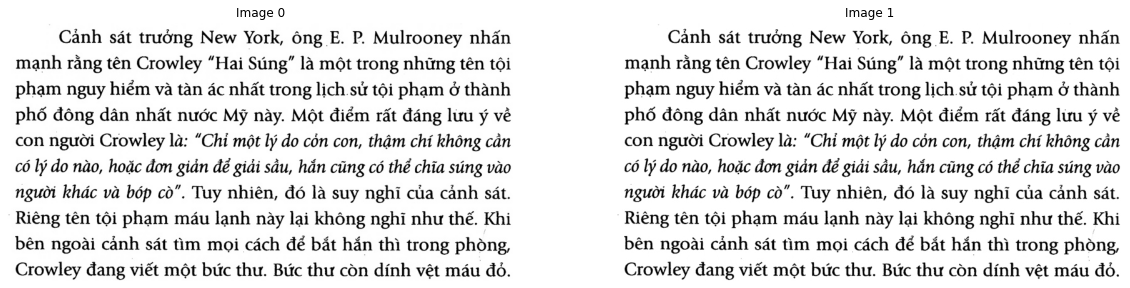

In [35]:
# Read Image
image_color, image_gray = read_image("Lab07 - Image/Newspaper.jpg")
# Display Image
ShowImage([image_color, image_gray], 1, 2)

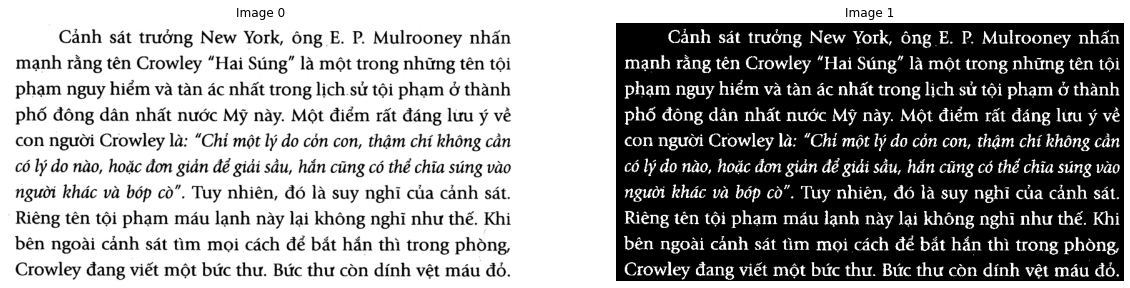

In [39]:
thresh, image_mask = cv2.threshold(image_gray,150,255,cv2.THRESH_BINARY_INV)
ShowImage([image_gray, image_mask], 1, 2)

In [40]:
def morphological_dilation(image_mask, image_color, kernel_size = None, iterations = 2, threshold = 10):
    if kernel_size == None:
        kernel = np.ones((3,3),np.uint8)
    else:
        kernel = np.ones(kernel_size,np.uint8)
    image_dilated = cv2.dilate(image_mask, kernel, iterations = iterations)
    result = image_color.copy()
    contours, hierarchy = cv2.findContours(image_dilated,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    count = 0
    DataDF = pd.DataFrame(columns = ["x", "y", "w", "h"])
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        if(w * h > threshold):
            cv2.rectangle(result,(x,y),(x+w,y+h),(0,255,0),2)
            DataDF.loc[count,:] = (x,y,w,h)
            count = count + 1
    DataDF = DataDF.astype(int)
    return DataDF, result, image_dilated

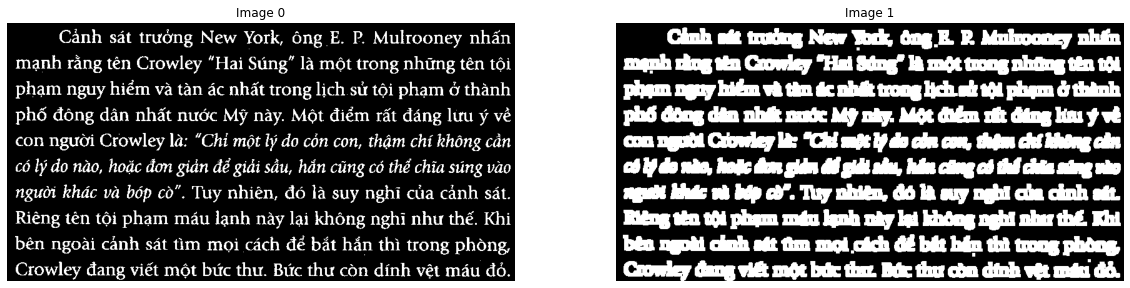

In [41]:
DataDF, result_dilated, image_dilated = morphological_dilation(image_mask, image_color, threshold = 300)
ShowImage([image_mask, image_dilated], 1, 2)

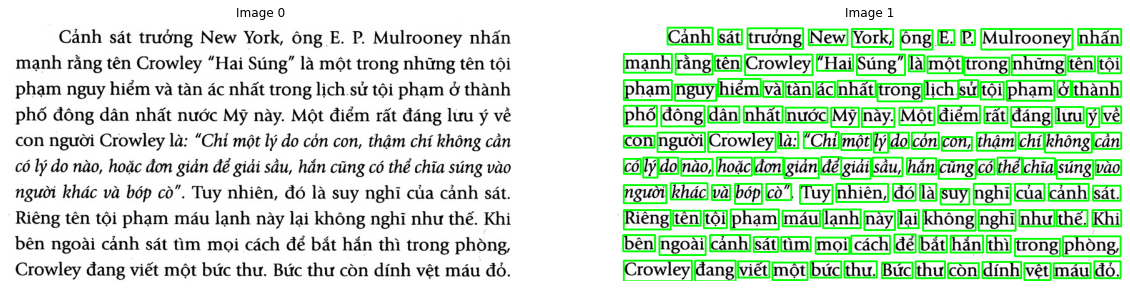

In [42]:
ShowImage([image_color, result_dilated], 1, 2)

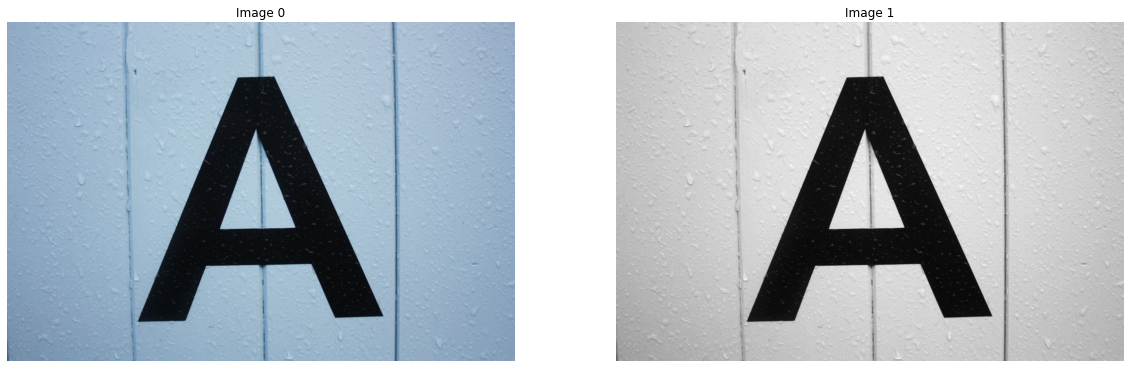

In [47]:
# Read Image
image_color, image_gray = read_image("Lab07 - Image/Alphabet.jpg")
# Display Image
ShowImage([image_color, image_gray], 1, 2)

In [48]:
def get_label_objs(image_mor, image_gray):
    from skimage.measure import label, regionprops
    image_mask = image_mor.copy()
    image_label = label(image_mask) # Label each area in the image from 1 to n
    
    regions = regionprops(image_label, intensity_image=image_gray, coordinates='rc')
    ColList = ["label", "at_row", "at_col",
    "area", "minr", "minc", "maxr", "maxc", "width", "height",
    "max_intensity", "mean_intensity", "min_intensity",]
    
    LabelDF = pd.DataFrame(columns = ColList)
    for props in regions:
        RowList = []
        label = props.label
        if("label" in ColList):
            RowList.append(label)
            
        at_row, at_col = props.centroid
        if("at_row" in ColList):
            RowList.append(at_row)
            
        if("at_col" in ColList):
            RowList.append(at_col)
            
        if("area" in ColList):
            RowList.append(props.area)
            
        minr, minc, maxr, maxc = props.bbox
        if("minr" in ColList):
            RowList.append(minr)
            
        if("minc" in ColList):
            RowList.append(minc)
            
        if("maxr" in ColList):
            RowList.append(maxr)
            
        if("maxc" in ColList):
            RowList.append(maxc)
            
        if("width" in ColList):
            RowList.append(maxc - minc)
            
        if("height" in ColList):
            RowList.append(maxr - minr)
            
        if("max_intensity" in ColList):
            RowList.append(props.max_intensity)
            
        if("mean_intensity" in ColList):
            RowList.append(props.mean_intensity)
            
        if("min_intensity" in ColList):
            RowList.append(props.min_intensity)
            
        LabelDF.loc[label-1, 0 : len(RowList)] = RowList
    LabelDF = LabelDF.sort_values(by = "area", ascending = False).reset_index(drop = True)
    return image_label, LabelDF

In [49]:
def mask_area_obj(result, LabelDF, idx, color = (0,255,0)):
    x = int(LabelDF.loc[idx, "minc"])
    y = int(LabelDF.loc[idx, "minr"])
    w = int(LabelDF.loc[idx, "width"])
    h = int(LabelDF.loc[idx, "height"])
    cv2.rectangle(result,(x,y),(x+w,y+h),color,5)
    return result

In [50]:
def morphological_erosion(image_gray, kernel_size = None, iterations = 1, threshold = 50):
    thresh, image_mask = cv2.threshold(image_gray,threshold,255,cv2.THRESH_BINARY_INV)
    
    if kernel_size == None:
        kernel = np.ones((3,3),np.uint8)
    else:
        kernel = np.ones(kernel_size, np.uint8)
    image_erosion = cv2.erode(image_mask,kernel,iterations = iterations)
    return image_mask, image_erosion

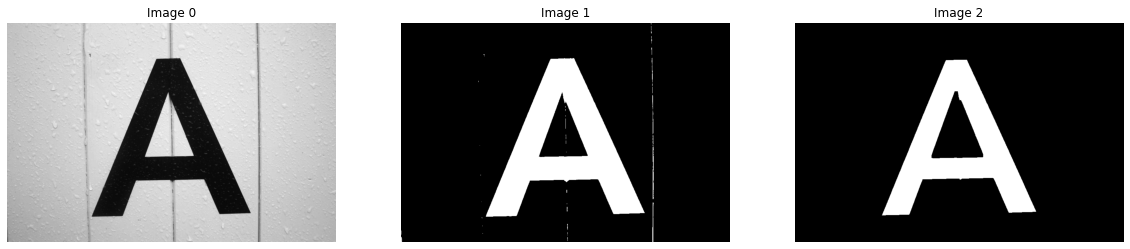

In [52]:
image_mask, image_erosion = morphological_erosion(image_gray, kernel_size = (5,5), iterations = 2, threshold = 100)
ShowImage([image_gray, image_mask, image_erosion], 1, 3)

In [53]:
image_label, LabelDF = get_label_objs(image_erosion, image_gray)
LabelDF.head()

label   at_row   at_col   area minr minc maxr maxc width height  \
0     1  376.547  495.912  80270  112  264  586  733   469    474   

  max_intensity mean_intensity min_intensity  
0            69        15.4877             4

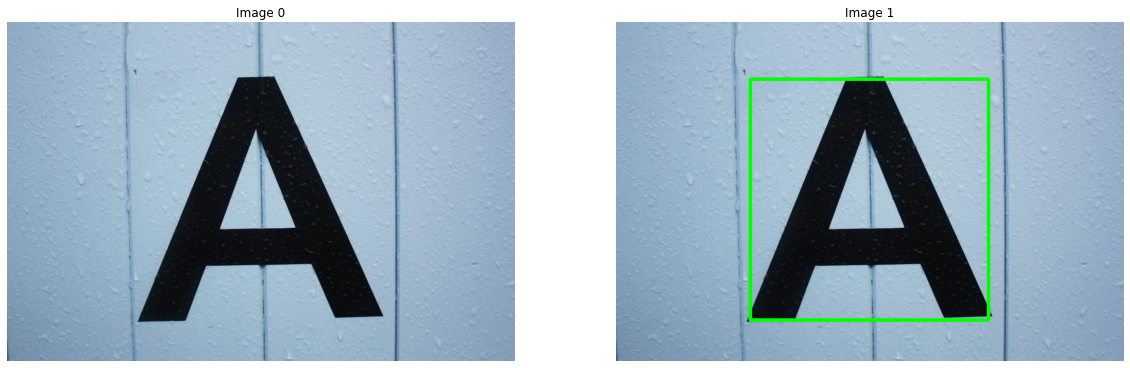

In [54]:
result_erosion = image_color.copy()
result_erosion = mask_area_obj(result_erosion, LabelDF, idx = 0)
ShowImage([image_color, result_erosion], 1, 2)

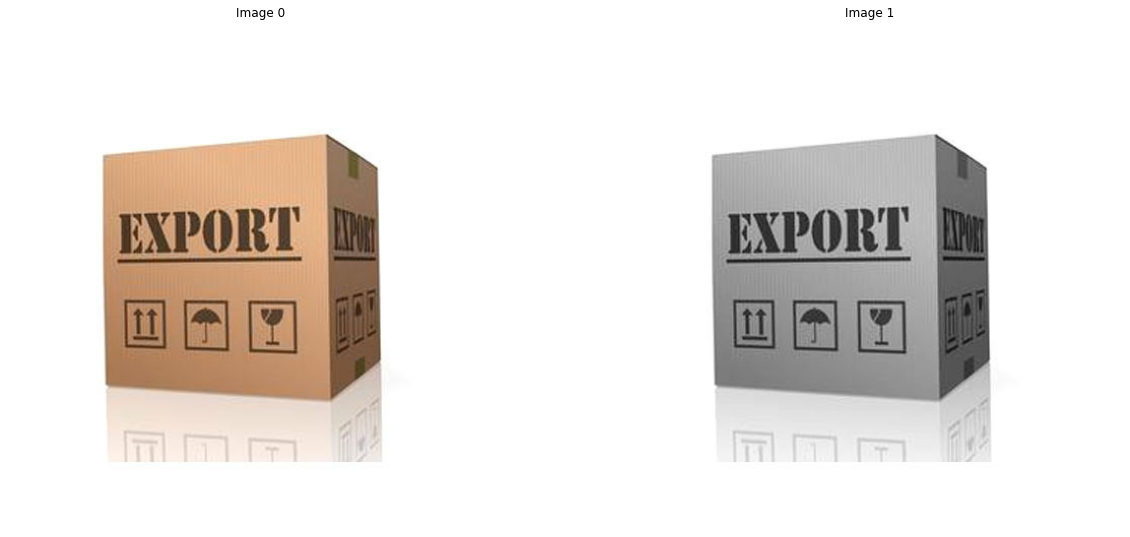

In [58]:
# Read Image
image_color, image_gray = read_image("Lab07 - Image/Carton Box.jpg")
# Display Image
ShowImage([image_color, image_gray], 1, 2)

In [59]:
def morphological_closing(image_gray, kernel_size = None, iterations = 1, threshold = 50):
    thresh, image_mask = cv2.threshold(image_gray,threshold,255,cv2.THRESH_BINARY_INV)
    
    if kernel_size == None:
        kernel = np.ones((3,3),np.uint8)
    else:
        kernel = np.ones(kernel_size,np.uint8)
    image_closing = cv2.morphologyEx(image_mask, cv2.MORPH_CLOSE, kernel,iterations = iterations)
    
    from scipy import ndimage as ndi
    image_fill = ndi.binary_fill_holes(image_closing)
    
    return image_mask, image_closing, image_fill

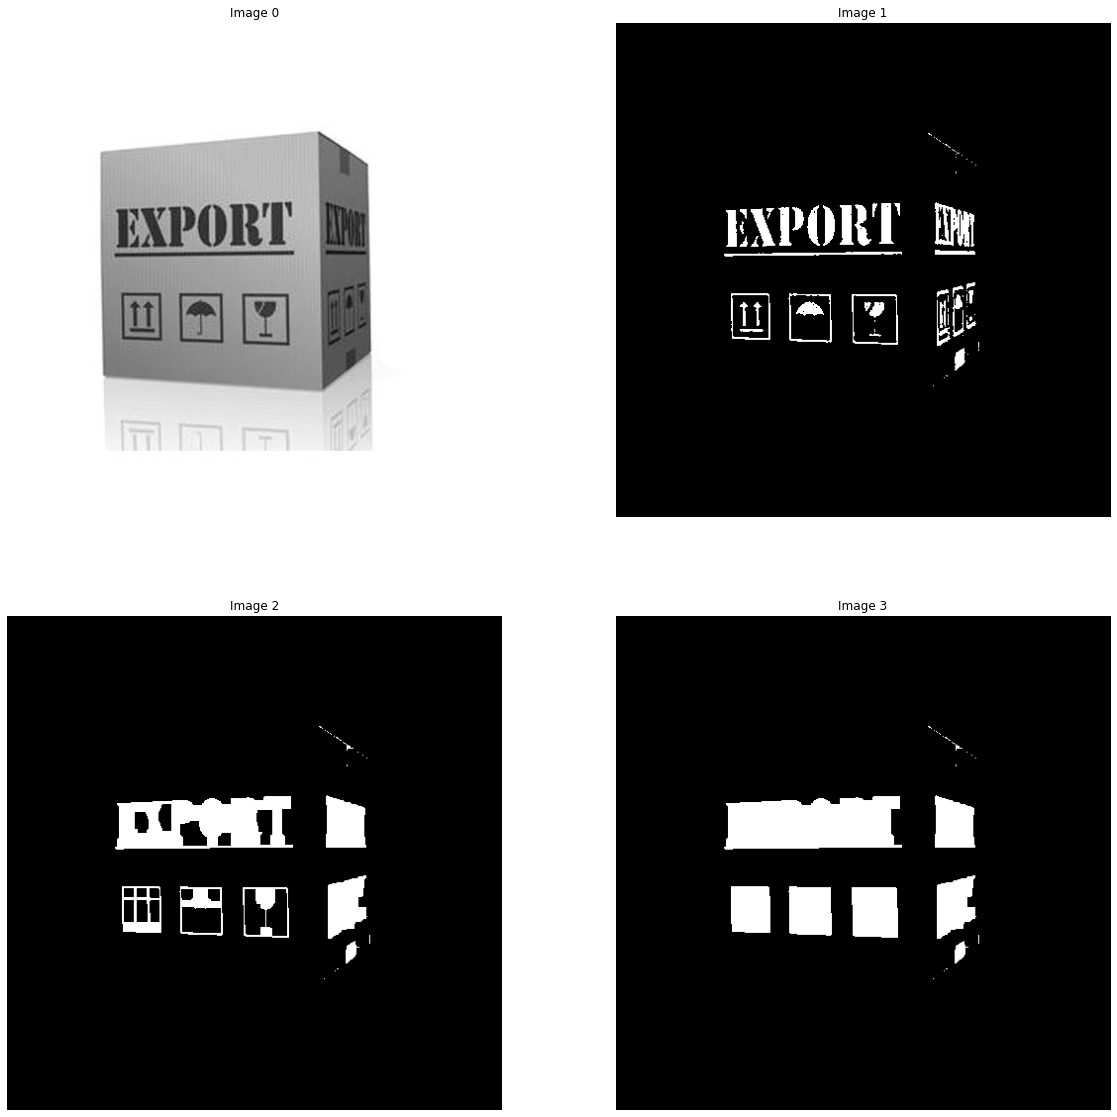

In [60]:
image_mask, image_closing, image_fill = morphological_closing(image_gray, kernel_size = (5,5), iterations = 2, threshold = 80)
ShowImage([image_gray, image_mask, image_closing, image_fill], 2, 2)

In [61]:
image_label, LabelDF = get_label_objs(image_fill, image_gray)
LabelDF.head(10)

label   at_row   at_col  area minr minc maxr maxc width height  \
0    13  210.809  197.717  8168  183  109  237  289   180     54   
1    17  299.684  261.229  2311  275  238  326  285    47     51   
2    16  298.491  195.776  2043  274  174  324  218    44     50   
3    15  296.858  135.567  1847  274  116  321  156    40     47   
4    12  211.149  340.704  1817  182  322  235  363    41     53   
5    14  292.933  341.047  1802  263  324  327  364    40     64   
6    19  339.711  346.928   180  329  342  352  356    14     23   
7     7  132.478  344.043    23  128  339  137  350    11      9   
8    18      327      366     9  323  366  332  367     1      9   
9     6  124.429  334.286     7  123  332  127  338     6      4   

  max_intensity mean_intensity min_intensity  
0           213        112.943            32  
1           188        130.193            44  
2           175        121.731            42  
3           174        114.315            35  
4           133        73.4172            15  
5           123        81.4401            23  
6            99          68.35            49  
7           128        90.1304            70  
8            81        77.1111            74  
9            76        73.4286            64

label   at_row   at_col  area minr minc maxr maxc width height  \
0    13  210.809  197.717  8168  183  109  237  289   180     54   
1    17  299.684  261.229  2311  275  238  326  285    47     51   
2    16  298.491  195.776  2043  274  174  324  218    44     50   
3    15  296.858  135.567  1847  274  116  321  156    40     47   
4    12  211.149  340.704  1817  182  322  235  363    41     53   
5    14  292.933  341.047  1802  263  324  327  364    40     64   

  max_intensity mean_intensity min_intensity  
0           213        112.943            32  
1           188        130.193            44  
2           175        121.731            42  
3           174        114.315            35  
4           133        73.4172            15  
5           123        81.4401            23

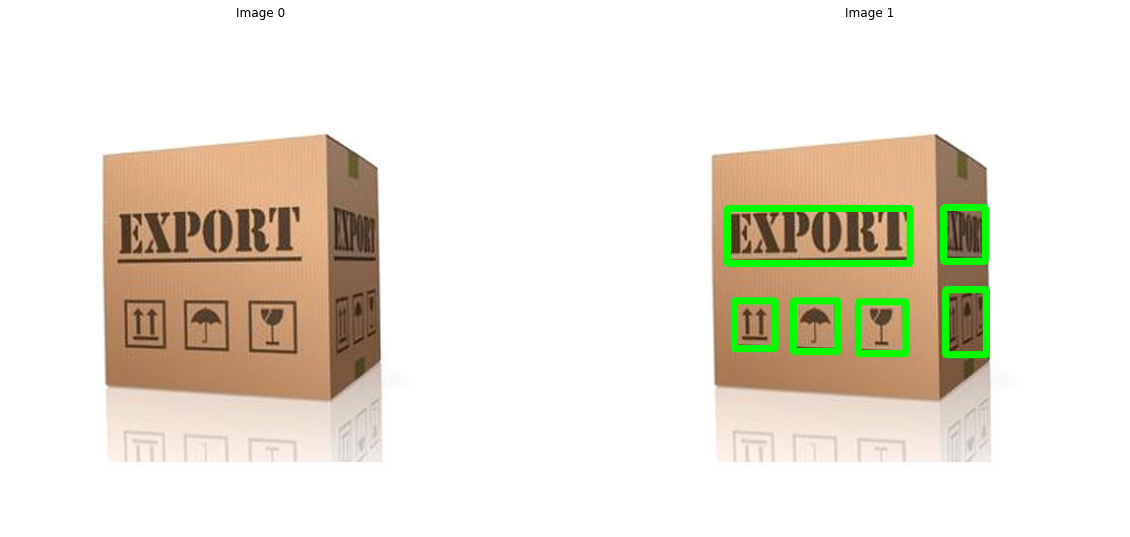

In [62]:
FindDF = LabelDF[LabelDF['area'] > 200]
display(FindDF)
result_closing = image_color.copy()
for idx in FindDF.index:
    result_closing = mask_area_obj(result_closing, FindDF, idx = idx)

ShowImage([image_color, result_closing], 1, 2)

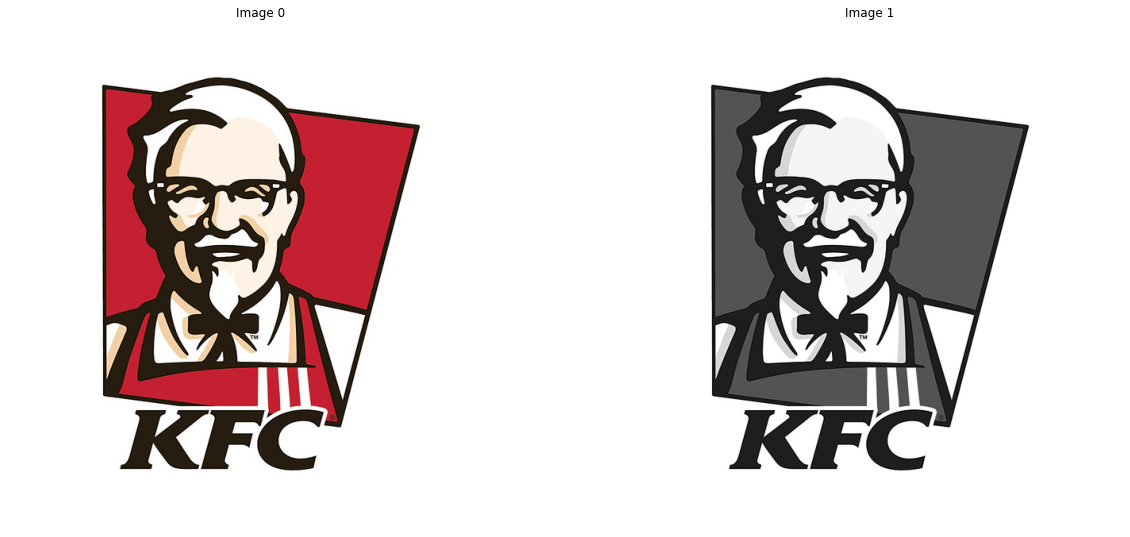

In [63]:
# Read Image
image_color, image_gray = read_image("Lab07 - Image/KFC.jpg")
# Display Image
ShowImage([image_color, image_gray], 1, 2)

In [65]:
def morphological_gradient(image_color, kernel_size = None, threshold = 50):
    image_gray = cv2.cvtColor(image_color, cv2.COLOR_RGB2GRAY)
    thresh, image_mask = cv2.threshold(image_gray,threshold,255,cv2.THRESH_BINARY_INV)
    
    if kernel_size == None:
        kernel = np.ones((3,3),np.uint8)
    else:
        kernel = np.ones(kernel_size,np.uint8)
    image_gradient = cv2.morphologyEx(image_mask, cv2.MORPH_GRADIENT, kernel)

    image_mask_color = cv2.bitwise_and(image_color, image_color, mask = image_mask)
    image_gradient_color = cv2.bitwise_and(image_color, image_color, mask = image_gradient)
    
    return image_mask, image_gradient, image_mask_color, image_gradient_color

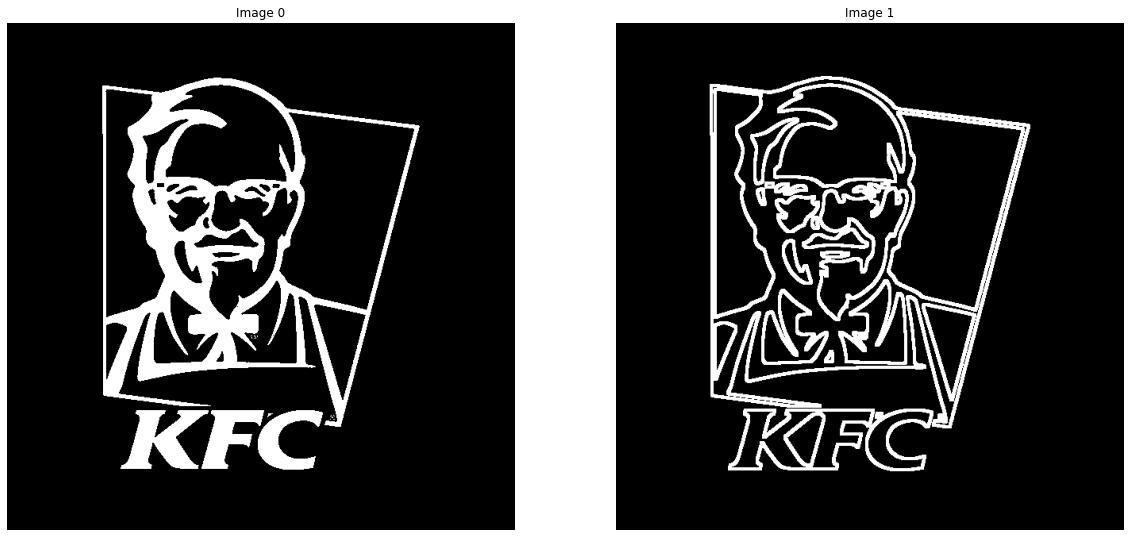

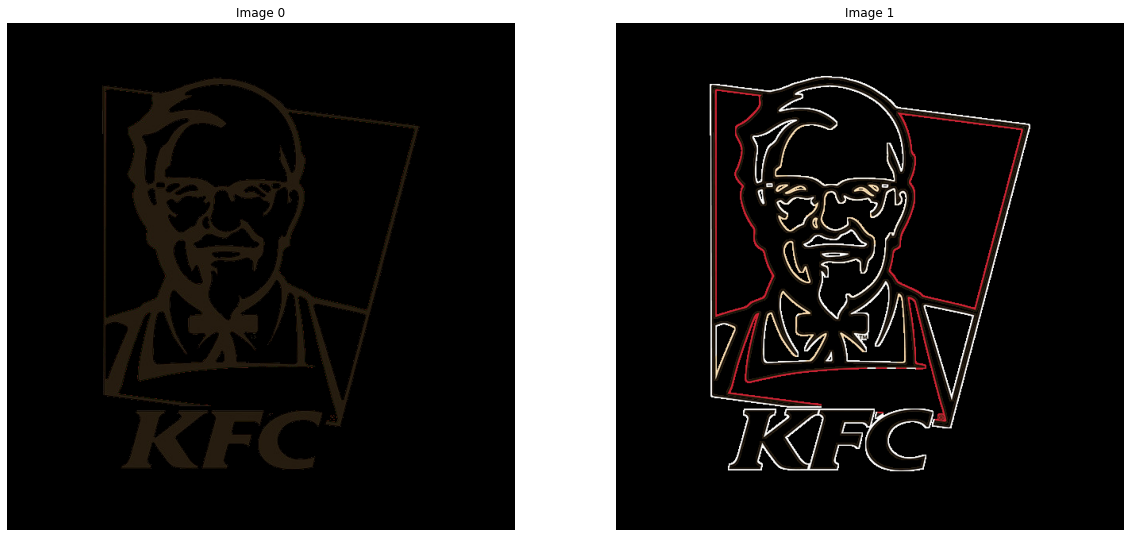

In [67]:
image_mask, image_gradient, image_mask_color, image_gradient_color = morphological_gradient(image_color, kernel_size = (5,5), threshold = 50)

ShowImage([image_mask, image_gradient], 1, 2)
ShowImage([image_mask_color, image_gradient_color], 1, 2)

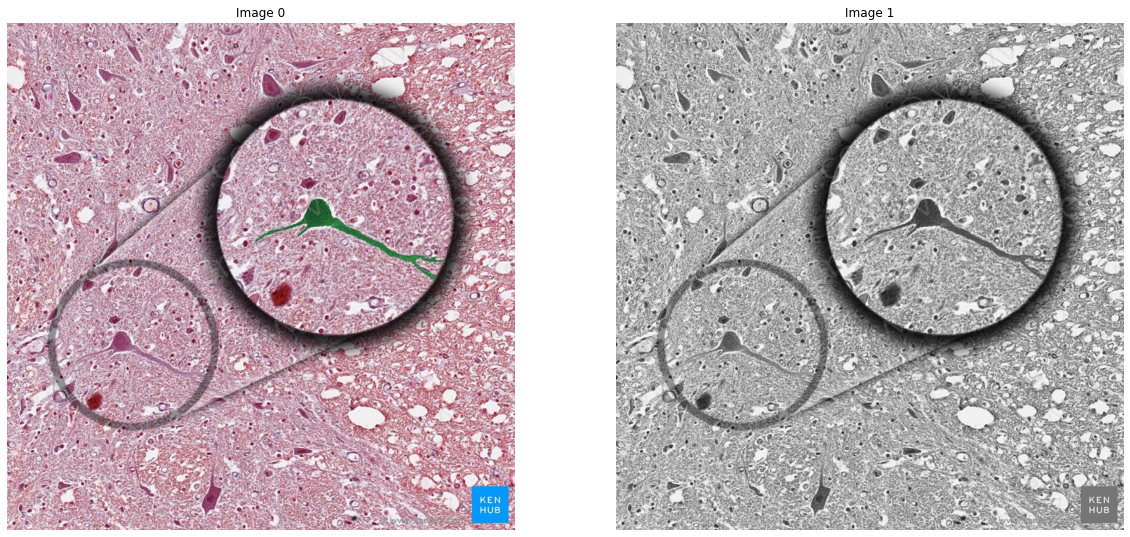

In [71]:
# Read Image
image_color, image_gray = read_image("Lab07 - Image/cell.jpg")
# Display Image
ShowImage([image_color, image_gray], 1, 2)

In [75]:
def morphological_opening(image_color, kernel_size = None, iterations = 1, threshold = 50):
    image_gray = cv2.cvtColor(image_color, cv2.COLOR_RGB2GRAY)
    thresh, image_mask = cv2.threshold(image_gray,threshold,255,cv2.THRESH_BINARY_INV)
    
    if kernel_size == None:
        kernel = np.ones((3,3),np.uint8)
    else:
        kernel = np.ones(kernel_size,np.uint8)
        
    image_erosion = cv2.erode(image_mask,kernel,iterations = iterations)
    image_mask = image_erosion.copy()
    
    image_opening = cv2.morphologyEx(image_mask, cv2.MORPH_OPEN, kernel)
    image_opening_color = cv2.bitwise_and(image_color, image_color, mask = image_opening)
    
    return image_mask, image_opening, image_opening_color

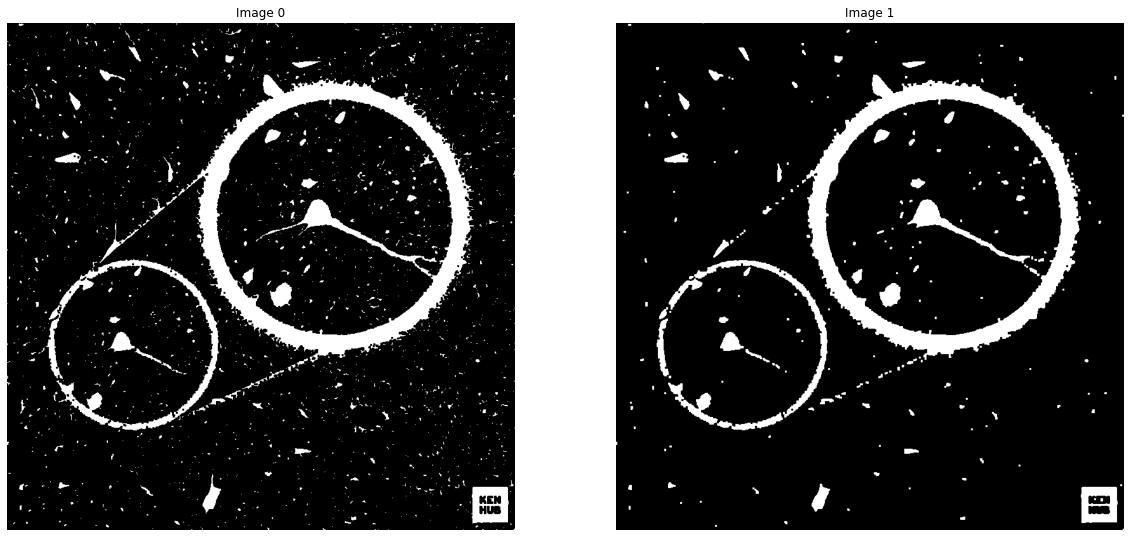

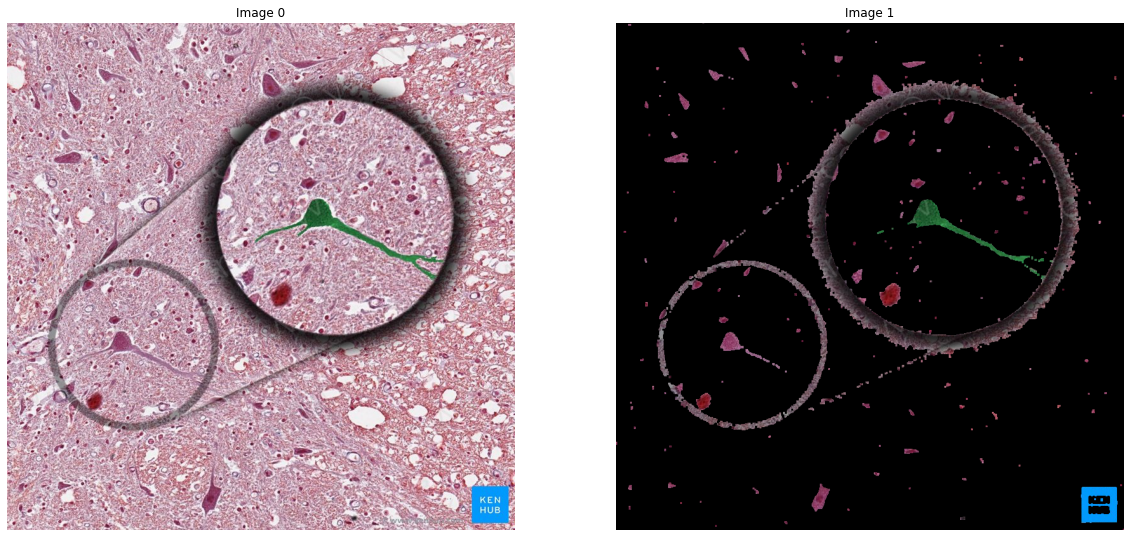

In [76]:
image_mask, image_opening, image_opening_color = morphological_opening(image_color, iterations = 1, threshold = 150)

ShowImage([image_mask, image_opening], 1, 2)
ShowImage([image_color, image_opening_color], 1, 2)